# Import

In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
from matplotlib import pyplot as plt
from sklearn.model_selection import GroupShuffleSplit
from pytorch_tabnet.tab_model import TabNetClassifier
import torch
from torch import nn
from torch.utils.data import TensorDataset, DataLoader
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import average_precision_score, roc_auc_score, precision_recall_curve, roc_curve, ConfusionMatrixDisplay
import optuna
from sklearn.model_selection import GroupKFold

import tqdm

/home/clement/mnt/ssd_nvme/ai-med-portfolio/projects/dl/llc-mlp-tabnet/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Data exploration

In [2]:
data_dir = Path("..")
data = pd.read_csv(data_dir / "raw_data.csv", sep = ";")
data

,patient_name,cell_name,cell_type,patient_state,lambda_1,lambda_2,lambda_3,lambda_4,lambda_5,lambda_6,...,lambda_991,lambda_992,lambda_993,lambda_994,lambda_995,lambda_996,lambda_997,lambda_998,lambda_999,spectre
0,P2_ULC80,P2_ULC80_M1_L1_ROI1_C1,B,malade,86.256404,84.116425,83.269485,73.725729,69.172432,58.695397,...,345.330540,343.913899,340.570137,336.092245,329.088472,324.055107,314.110388,319.853392,335.922163,3.0
1,P2_ULC80,P2_ULC80_M1_L1_ROI1_C1,B,malade,72.367814,70.946072,73.946121,69.342146,66.510280,51.961781,...,329.497317,330.293120,334.239066,336.958602,332.810752,337.041213,329.390541,317.220241,289.615842,2.0
2,P2_ULC80,P2_ULC80_M1_L1_ROI1_C1,B,malade,36.107124,50.509171,61.251275,60.634079,59.005082,43.374480,...,349.773008,362.963878,377.543505,369.898047,347.525042,324.241500,304.862554,313.958545,356.180451,1.0
3,P2_ULC80,P2_ULC80_M1_L1_ROI1_C2,B,malade,75.073652,57.880571,53.339291,47.543917,51.896103,40.910901,...,316.498420,323.193044,321.317859,310.282294,326.497336,339.002563,345.054206,372.404114,414.603390,2.0
4,P2_ULC80,P2_ULC80_M1_L1_ROI1_C2,B,malade,51.591270,54.161436,63.649577,58.364222,61.095665,47.811723,...,324.027328,320.147621,318.339477,310.159782,313.315257,333.873758,339.270424,352.541981,351.914705,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7192,P1_ULC156,P1_ULC156_M1_L1_ROI2_C43,TNK,sain,79.899533,106.561057,113.545793,116.775563,108.161449,96.394401,...,353.242721,342.554395,338.234888,349.217179,354.196203,357.833444,369.658252,378.589869,394.833234,3.0
7193,P1_ULC156,P1_ULC156_M1_L1_ROI2_C43,TNK,sain,86.579106,64.318268,53.031208,60.351759,73.065302,72.644425,...,336.118073,345.712805,338.797810,339.772543,345.702042,353.963123,356.027565,351.790370,342.570314,1.0
7194,P1_ULC156,P1_ULC156_M1_L1_ROI2_C44,B,sain,86.193622,67.082583,62.158704,66.058526,76.819090,76.931321,...,340.361834,348.195007,342.144712,357.687618,361.788879,362.309974,358.883856,355.593313,357.331293,1.0
7195,P1_ULC156,P1_ULC156_M1_L1_ROI2_C44,B,sain,89.962557,89.573056,90.300399,93.353796,96.570792,104.798885,...,370.213484,370.174949,373.407591,379.524429,382.040521,376.632795,377.164771,366.349519,363.434051,2.0


In [3]:
print(data.isnull().sum())


patient_name     0
cell_name        0
cell_type        0
patient_state    0
lambda_1         0
                ..
lambda_996       0
lambda_997       0
lambda_998       0
lambda_999       0
spectre          0
Length: 1004, dtype: int64


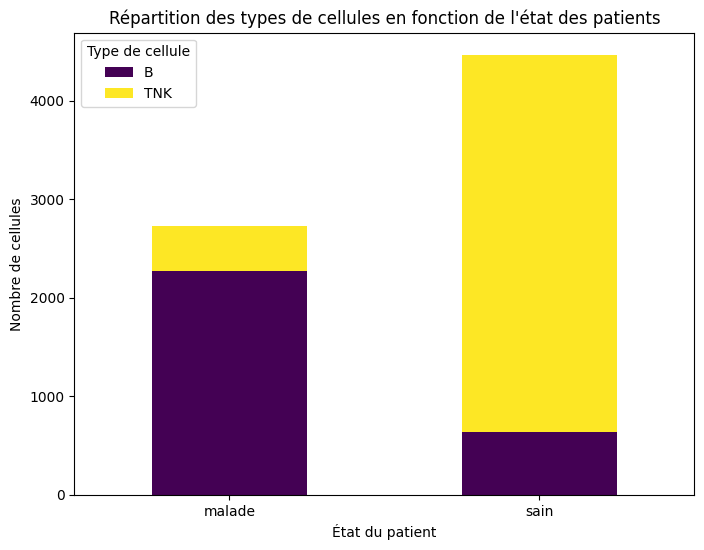

In [4]:
cell_state_distribution = data.groupby(['patient_state', 'cell_type']).size().unstack()

cell_state_distribution.plot(kind='bar', figsize=(8, 6), stacked=True, colormap='viridis')
plt.title("Répartition des types de cellules en fonction de l'état des patients")
plt.ylabel("Nombre de cellules")
plt.xlabel("État du patient")
plt.legend(title="Type de cellule")
plt.xticks(rotation=0)
plt.show()

# Pipeline

In [5]:
groups = data["patient_name"]
X_df = data.drop(columns = ["patient_state", "cell_name", "patient_name"])
y = (data["patient_state"]=="malade").astype(int)

cv = GroupKFold(n_splits=5)


In [6]:
num_cols = [col for col in X_df.columns if col.startswith("lambda_") or col.startswith("spectre")]
cat_col = ["cell_type"]


In [7]:
pipeline = ColumnTransformer(
    transformers = [
        ("num", Pipeline([
            ("scaler", StandardScaler()),
        ]), num_cols),
        ("cat", Pipeline([
            ("one_hot", OneHotEncoder(handle_unknown="ignore"))
            ]), cat_col),
    ], remainder = "drop"
    
)

In [8]:
device = "cuda" if torch.cuda.is_available() else "cpu"

# Model

In [9]:
class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim1, hidden_dim2, dropout):
        super(MLP, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, hidden_dim1),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim1,hidden_dim2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim2, 1))
        
    def forward(self,x):
        return self.model(x)

# Fonctions training / validation

In [10]:
class SimpleEarlyStopping:
    def __init__(self, patience=5, min_delta=0.0):
        self.patience = patience
        self.min_delta = min_delta
        self.best = None
        self.counter = 0
        self.early_stop = False

    def __call__(self, val_loss, model=None):
        if self.best is None or val_loss < self.best - self.min_delta:
            self.best = val_loss
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True


def validate_MLP_model(model, val_loader, loss_fn, device):
    model.eval()
    losses = []

    with torch.no_grad():
        for xb, yb in val_loader:
            xb = xb.to(device)
            yb = yb.to(device)

            logits = model(xb)                 # logits
            loss = loss_fn(logits, yb)         # scalar tensor
            losses.append(loss.item())

    return float(np.mean(losses))


def train_MLP_model(
    model,
    X_train, y_train,
    X_val, y_val,
    epochs=20,
    lr=1e-3,
    weight_decay = 1e-2,
    batch_size=256,
    device="cpu",
    early_stopper=None,
    patience = 5, 
    min_delta = 0.0,
):
    
    if early_stopper is True:
        early_stopper = SimpleEarlyStopping(patience=patience, min_delta=min_delta)
    elif early_stopper is False:
        early_stopper = None
        
    # DataLoaders
    train_loader = DataLoader(
        TensorDataset(X_train, y_train),
        batch_size=batch_size,
        shuffle=True
    )
    val_loader = DataLoader(
        TensorDataset(X_val, y_val),
        batch_size=batch_size,
        shuffle=False
    )
    pos = y_train.sum()
    neg = len(y_train) - pos
    pos_weight = torch.tensor([neg / max(pos, 1)], dtype=torch.float32).to(device)
    loss_fn = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay = weight_decay)

    model.to(device)

    best_val = float("inf")
    best_state = None
    val_losses = []
    for ep in range(epochs):
        model.train()

        for xb, yb in train_loader:
            xb = xb.to(device)
            yb = yb.to(device)

            optimizer.zero_grad()
            logits = model(xb)                 # logits
            loss = loss_fn(logits, yb)
            loss.backward()
            optimizer.step()

        val_loss = validate_MLP_model(model, val_loader, loss_fn, device)

        # sauvegarde best
        if val_loss < best_val:
            best_val = val_loss
            best_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}

        # early stopping 
        if early_stopper is not None:
            early_stopper(val_loss, model)
            if getattr(early_stopper, "early_stop", False):
                break
        val_losses.append(val_loss)

    if best_state is not None:
        model.load_state_dict(best_state)
        
        

    return model, best_val, val_losses


# fine best hyperparameters

In [11]:

def objective(trial):
    
    hidden_dim1 = trial.suggest_int("hidden1", 64, 256, step=64)
    hidden_dim2 = trial.suggest_int("hidden2", 32, 128, step=32)
    dropout = trial.suggest_float("dropout", 0.0, 0.5)
    weight_decay = trial.suggest_float("weight_decay", 1e-6, 1e-2, log=True)
    lr = trial.suggest_float("lr", 1e-4, 3e-3, log=True)
    epochs = trial.suggest_int("epochs", 5, 30)
    batch_size = trial.suggest_categorical("batch_size", [128, 256, 512])
        
    fold_scores = []
    for tr_idx, val_idx in cv.split(X_df, y, groups = groups):
        X_tr, X_val = X_df.iloc[tr_idx], X_df.iloc[val_idx]
        y_tr, y_val = y.iloc[tr_idx], y.iloc[val_idx]
        
        X_tr = pipeline.fit_transform(X_tr)
        X_val = pipeline.transform(X_val)
    
        # tensors
        Xtr_t = torch.tensor(X_tr, dtype=torch.float32)
        Xva_t = torch.tensor(X_val, dtype=torch.float32)
        ytr_t = torch.tensor(y_tr.values, dtype=torch.float32).view(-1, 1)
        yva_t = torch.tensor(y_val.values, dtype=torch.float32).view(-1, 1)

        model = MLP(
            input_dim=X_tr.shape[1], 
            hidden_dim1=hidden_dim1,
            hidden_dim2=hidden_dim2,
            dropout=dropout
        )

        model,_,_ = train_MLP_model(
            model,
            Xtr_t, ytr_t,
            Xva_t, yva_t,
            epochs=epochs,
            lr=lr,
            weight_decay = weight_decay,
            batch_size=batch_size,
            device=device,
            early_stopper=None
        )

        model.eval()
        with torch.no_grad():
            logits = model(Xva_t.to(device)).cpu().numpy().ravel()
        y_proba = 1 / (1 + np.exp(-logits))

        score = roc_auc_score(y_val.values, y_proba)          # ROC-AUC
        fold_scores.append(score)

    return float(np.mean(fold_scores))
    

    

In [12]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=30)

print("Best:", study.best_params)


[I 2025-12-24 14:58:08,182] A new study created in memory with name: no-name-4e39a633-b29e-44f7-8d08-e36100f0b308
[I 2025-12-24 14:58:11,373] Trial 0 finished with value: 0.6190037251276601 and parameters: {'hidden1': 64, 'hidden2': 32, 'dropout': 0.3805464328180157, 'weight_decay': 8.567491982642884e-06, 'lr': 0.0001076404296024441, 'epochs': 17, 'batch_size': 512}. Best is trial 0 with value: 0.6190037251276601.
[I 2025-12-24 14:58:12,753] Trial 1 finished with value: 0.7432195455840825 and parameters: {'hidden1': 256, 'hidden2': 64, 'dropout': 0.4168576490278178, 'weight_decay': 0.003460253368404559, 'lr': 0.0008539477274634323, 'epochs': 8, 'batch_size': 512}. Best is trial 1 with value: 0.7432195455840825.
[I 2025-12-24 14:58:14,002] Trial 2 finished with value: 0.7135299868623656 and parameters: {'hidden1': 64, 'hidden2': 32, 'dropout': 0.07014672470187056, 'weight_decay': 0.0004787128654265622, 'lr': 0.0022120583451674804, 'epochs': 7, 'batch_size': 512}. Best is trial 1 with va

Best: {'hidden1': 192, 'hidden2': 128, 'dropout': 0.34460123136504106, 'weight_decay': 4.6173716897668325e-05, 'lr': 0.0015924695010984646, 'epochs': 19, 'batch_size': 128}


# Split train/val/test

In [13]:

gss = GroupShuffleSplit(n_splits=1, test_size=0.20, random_state=42)
train_idx, test_idx = next(gss.split(X_df, y, groups=groups))

X_train_df, X_test_df = X_df.iloc[train_idx], X_df.iloc[test_idx]
y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
groups_train = groups.iloc[train_idx]

gss2 = GroupShuffleSplit(n_splits=1, test_size=0.20, random_state=42)
train2_idx, val_idx = next(gss2.split(X_train_df, y_train, groups=groups_train))

X_tr_df, X_val_df = X_train_df.iloc[train2_idx], X_train_df.iloc[val_idx]
y_tr, y_val = y_train.iloc[train2_idx], y_train.iloc[val_idx]

# Preprocess

In [14]:
X_train = pipeline.fit_transform(X_tr_df)
X_val = pipeline.transform(X_val_df)
X_test = pipeline.transform(X_test_df)

In [15]:
best = study.best_params

In [16]:
def sigmoid(x):
    return 1/(1+np.exp(-x))

# Training

In [17]:
model = MLP(
            input_dim=X_train.shape[1], 
            hidden_dim1=best["hidden1"],
            hidden_dim2=best["hidden2"],
            dropout=best["dropout"]
        )

Xtr_t = torch.tensor(X_train, dtype=torch.float32)
Xva_t = torch.tensor(X_val, dtype=torch.float32)
Xtest_t = torch.tensor(X_test, dtype=torch.float32)
ytr_t = torch.tensor(y_tr.values, dtype=torch.float32).view(-1, 1)
yva_t = torch.tensor(y_val.values, dtype=torch.float32).view(-1, 1)
ytest_t = torch.tensor(y_test.values, dtype=torch.float32).view(-1, 1)

model,_, val_losses = train_MLP_model(
    model,
    Xtr_t, ytr_t,
    Xva_t, yva_t,
    epochs=best["epochs"],
    lr=best["lr"],
    weight_decay = best["weight_decay"],
    batch_size=best["batch_size"],
    device=device,
    early_stopper=True,
    patience = 5,
    
)

with torch.no_grad():
    val_logits = model(Xva_t.to(device)).cpu().numpy().ravel()
    test_logits = model(Xtest_t.to(device)).cpu().numpy().ravel()

val_proba = sigmoid(val_logits)
test_proba = sigmoid(test_logits)

# Test model

In [18]:

def pick_threshold_for_min_recall(y_true, y_proba, min_recall=0.80):
    prec, rec, thr = precision_recall_curve(y_true, y_proba)
    thr = np.r_[thr, 1.0]
    ok = np.where(rec >= min_recall)[0]
    if len(ok) == 0:
        return float(thr[np.argmax(rec)])
    idx = ok[np.argmax(thr[ok])]
    return float(thr[idx])


def plot_roc_pr(y_true, y_proba, name="model"):
    fpr, tpr, _ = roc_curve(y_true, y_proba)
    plt.figure(figsize=(5,4))
    plt.plot(fpr, tpr)
    plt.plot([0,1], [0,1], linestyle="--")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"ROC curve - {name}")
    plt.tight_layout()
    # plt.savefig(FIG_DIR / f"roc_{name}.png", dpi=200)
    plt.show()

    prec, rec, _ = precision_recall_curve(y_true, y_proba)
    plt.figure(figsize=(5,4))
    plt.plot(rec, prec)
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title(f"PR curve - {name}")
    plt.tight_layout()
    # plt.savefig(FIG_DIR / f"pr_{name}.png", dpi=200)
    plt.show()

def show_confusion(y_true, y_proba, threshold=0.5, name="model"):
    y_pred = (y_proba >= threshold).astype(int)
    ConfusionMatrixDisplay.from_predictions(y_true, y_pred, values_format="d")
    plt.title(f"Confusion matrix - {name} : thr={threshold:.2f}")
    plt.tight_layout()
    # plt.savefig(FIG_DIR / f"cm_{name}_thr_{threshold:.2f}.png", dpi=200)
    plt.show()

Chosen threshold (recall>=0.80 on val): 0.35560235381126404


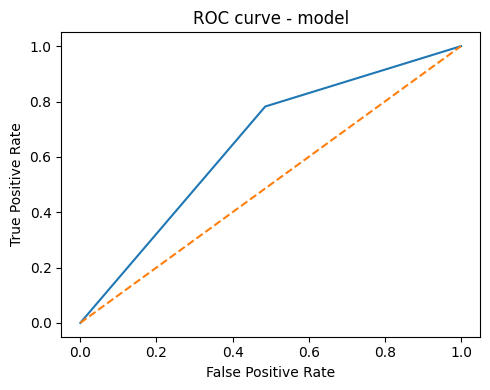

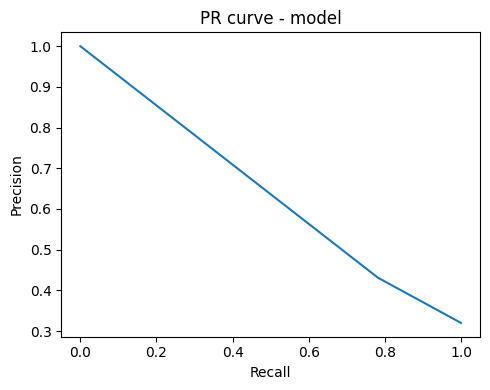

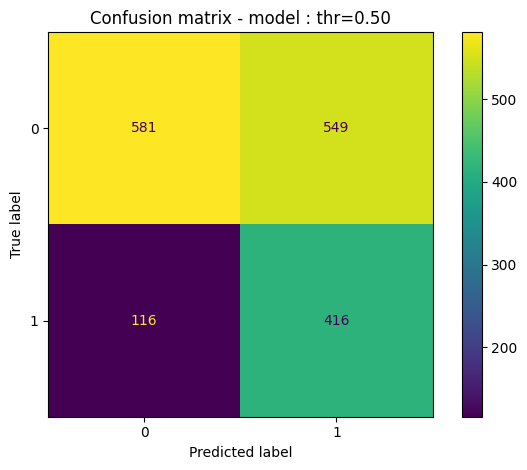

In [22]:

thr = pick_threshold_for_min_recall(y_val.values, val_proba, min_recall=0.80)
print("Chosen threshold (recall>=0.80 on val):", thr)

test_pred = (test_proba >= thr).astype(int)
plot_roc_pr(y_test, test_pred)
show_confusion(y_test, test_pred)


In [ ]:
def permutation_importance_manual(
    X, y, predict_proba_fn,
    metric="pr_auc",
    n_repeats=3,
    random_state=42
):
    rng = np.random.default_rng(random_state)

    # baseline
    base_proba = predict_proba_fn(X)
    if metric == "roc_auc":
        base_score = roc_auc_score(y, base_proba)
        score_fn = roc_auc_score
    else:
        base_score = average_precision_score(y, base_proba)  # PR-AUC
        score_fn = average_precision_score

    importances = np.zeros(X.shape[1], dtype=float)

    for j in range(X.shape[1]):
        scores = []
        for _ in range(n_repeats):
            X_perm = X.copy()
            idx = rng.permutation(X.shape[0])
            X_perm[:, j] = X_perm[idx, j]

            p = predict_proba_fn(X_perm)
            scores.append(score_fn(y, p))

        importances[j] = base_score - np.mean(scores)  # drop in performance

    return base_score, importances


def predict_proba_mlp(X_np):
    X_t = torch.tensor(X_np, dtype=torch.float32).to(device)
    model.eval()
    with torch.no_grad():
        logits = model(X_t).cpu().numpy().ravel()
    return 1 / (1 + np.exp(-logits))


In [26]:
base, imp = permutation_importance_manual(
    X_test, y_test.values, predict_proba_mlp,
    metric="pr_auc", n_repeats=3
)

feature_names = pipeline.get_feature_names_out()

top_idx = np.argsort(imp)[::-1][:20]

df_top20 = pd.DataFrame({
    "feature": np.array(feature_names)[top_idx],
    "importance": np.array(imp)[top_idx],
})
df_top20

,feature,importance
0,cat__cell_type_B,0.020808
1,cat__cell_type_TNK,0.020378
2,num__lambda_123,0.006132
3,num__lambda_122,0.005800
4,num__lambda_124,0.005562
5,num__lambda_172,0.005359
6,num__lambda_111,0.004707
7,num__lambda_125,0.004441
8,num__lambda_175,0.004045
9,num__lambda_98,0.004036
